In [1]:
import asyncio
import datetime
import threading
import firebase_admin
from firebase_admin import credentials, firestore, auth
from google.cloud.firestore import AsyncClient
import pandas as pd
import random

cred = credentials.Certificate('serviceAccountKey.json')
default_app = firebase_admin.initialize_app(cred)
# db = firestore.client(app = app)
async_db = AsyncClient(credentials=default_app.credential.get_credential(), project=default_app.project_id)
# Instance of firestore db
db = firestore.client()

In [2]:
userIdsCollections = ['06TgfRGj5ssVFQBR', '0RNSh7XU6uxKkX95', '1KNmLbYCKBtGGeRb', '2O7Sxjk2K8Z9Zbir',
                                    '2Pnzu3gOeCMm4XqG', '4V2CAn67SvEOXq7W', '5z1WWM9GyoJPMwzK', '6M6mnXyTDWocyjOy',
                                    '7M0sJiKQi57WNlPd', '7MXV1mY9i3f1WQzE11ZdG7EvATx1', '7ZSF4qu83lBeX8Mf',
                                    '8OQ8W2v6nOT4y3kqYqvVXFpQOaT2', '9TOfKVTRJw2GXL0E', 'A7or1pGHqPB87d1g',
                                    'BD00IjRpBbIesc96', 'CVWpmQBh40FnZpdf', 'EpFs6znr8rV3P45o', 'G42AgiBH62PCzzIv',
                                    'GWkEwboOmHevXHfdhIyiWCAfDE22', 'HsguOfulSC1rmRza', 'JE8ejjw6V5ZKWyc0',
                                    'JcBQeIY2lv3aP2c2', 'Jfzz4niuLuR00Ty8Hhhy9qg7sp03', 'LFAAW0t42BcmbKVC',
                                    'Mhmx4VaaaU6CSJjc', 'O7U1VF2QsZmMTG2k', 'OExxnIeegddEjCTi', 'Qe2hI1HfesfGvVIr',
                                    'QlGDU3do5BS6YZSkeJUN0Npls7D3', 'QvV4OoZmZ3QWHhMNaZrr7lkqmLF3',
                                    'R9HzkBlt9qdmWOIeDOuPnTT7tWi1', 'RrwcrMpbiKUz5djt5I1XBQf643J2',
                                    'VWZ57xjn7ZfvxPdg',
                                    'WDG6Cfh5aNuxWVGc', 'WbZZuRPhxRf6KL1GFHcNWL2Ydzk1', 'X1HPpb0RT5Y9hh6C',
                                    'X3KkZqZQo6NJGupn', 'XOurlov0DxZSp561zDqIfv3pqlt1', 'XmO1QXLV10BnnO8S',
                                    'YFVdbEfVCLGaW6SL', 'YbTlos4mEX6mRo0A', 'YovGQexpE9oXMCtC', 'ZZCKYcm2tW8dG8LG',
                                    'ZgwTr7S2oPaKpALV', 'a6yJBDhqjfr2vvF2', 'a79GFq2F1yATOWu2', 'aF6BqbMvkHiXt52N',
                                    'eVsTeXVjOFbDc48x', 'fGjPbsQq62IDvHVG', 'fv2RC90px78DuIrN', 'fvLGMuWzzbFnO7KV',
                                    'hwFIcicYwPXYsL88n55fll7JuEM2', 'jaOQPePYT510dyin', 'k692VKviEbXULblA',
                                    'lNJkCUfWiUtBGjMs', 'nOVgZ08Co4NS5p96', 'nhoXRc3wBSbU9YF9pMbSRDmIh8h2',
                                    'p7Gws6QkWxz0v4lm', 'penesHeuqWtQu5ZA', 'sCZ7nWrH1uR4QfAGj6Ndz4Cp3Vv2',
                                    'wClaPCcm3Qblg5YBYO7qQdOdJdn2', 'xUNQA8a6ShBk8vg7', 'y39LCk1SCOw2gBiG',
                                    'yCvln20Ent2yvYf5', 'zI9DqdXcrEenpKk8QjccnNVY4KA3', 'zopU4FMeBKzzQx7z']

In [2]:
####################################
# Async functions to be used internally for service jobs
####################################
# Get all profiles which user Liked
async def user_liked_profiles(userId=None):
    return await async_get_profiles_from_subcollection(collectionName=u'LikesDislikes',userId=userId,collectionNameChild=u'Likes')
# Get all profiles which user disliked 
async def user_disliked_profiles(userId=None):
    return await async_get_profiles_from_subcollection(collectionName=u'LikesDislikes',userId=userId,collectionNameChild=u'Dislikes')
# All Profiles which disliked the user
async def user_superliked_profiles(userId=None):
    return await async_get_profiles_from_subcollection(collectionName=u'LikesDislikes',userId=userId,collectionNameChild=u'Superlikes')
# All Profiles which liked the user
async def profiles_which_liked_user(userId=None):
    return await async_get_profiles_from_subcollection(collectionName=u'LikesDislikes',userId=userId,collectionNameChild=u'LikedBy')
# All Profiles which superliked the user
async def profiles_which_superliked_user(userId=None):
    return await async_get_profiles_from_subcollection(collectionName=u'LikesDislikes',userId=userId,collectionNameChild=u'SuperlikedBy')
# All Profiles which disliked the user
async def profiles_which_disliked_user(userId=None):
    return await async_get_profiles_from_subcollection(collectionName=u'LikesDislikes',userId=userId,collectionNameChild=u'DislikedBy')

# Get profile for a certain id 
async def async_get_profile_for_id(profileId=None):
    profile_ref = async_db.collection('Profiles')
    doc = await profile_ref.document(profileId).get()
    doctemp = doc.to_dict()
    doctemp["id"] = doc.id  # un-comment for production
    return doctemp

# Get list of proile ids from a certain collection
async def async_get_profiles_from_subcollection(collectionName=None, userId=None, collectionNameChild=None):
    collection_ref = async_db.collection(collectionName)
    collection_ref_likedislike_userIds = collection_ref.document(userId)
    collection_ref_second_child = collection_ref_likedislike_userIds.collection(collectionNameChild)
    docs = collection_ref_second_child.stream()
    userIds = [doc.to_dict()['id'] async for doc in docs]
    return userIds

In [34]:
async def calculate_popularity_score(userId):
    """
        superlike -- +4
        like -- +2
        dislike -- -1
    """
    liked_by_list = await profiles_which_liked_user(userId=userId)
    disliked_by_list = await profiles_which_disliked_user(userId=userId)
    superliked_by_list = await profiles_which_superliked_user(userId=userId)
    return (4 * len(superliked_by_list)) + (2 * len(liked_by_list)) - len(disliked_by_list)

async def get_profile_completion_score(userId):
    profile = await async_get_profile_for_id(profileId=userId)
    return (float(profile['profileCompletion']) / 100) * 10

async def calculate_activity_score(userId):
    """
        superlike -- +4
        like -- +2
        dislike -- -1
    """
    user_like_list = await user_liked_profiles(userId=userId)
    user_dislike_list = await user_disliked_profiles(userId=userId)
    user_superlike_list = await user_superliked_profiles(userId=userId)
    return (4 * len(user_superlike_list)) + (2 * len(user_like_list)) + len(user_dislike_list)


# a user with more matches will be given more score
async def calculate_matching_score(userId):
    return random.uniform(0, 1)

async def calculate_total_score(userId):
    popularity_score = await calculate_popularity_score(userId=userId)
    profile_completion_score = await get_profile_completion_score(userId=userId)
    activity_score = await calculate_activity_score(userId=userId)
    matching_score  = await calculate_matching_score(userId=userId)
    all_profile_scores = {"userId":userId,
                        "popularity_score":popularity_score,
                        "profile_completion_score":profile_completion_score,
                        "activity_score":activity_score,
                        "matching_score":matching_score}
    return all_profile_scores
    # await store_profile_grading_firestore(userId=userId, total_score=total_score, popularity_score=popularity_score,
    #                                       profile_completion_score=profile_completion_score)
    print(f"profile popularity score for {userId}: {popularity_score}")
    print(f"profile completion score for {userId}: {profile_completion_score}")
    print(f"profile grading score for {userId}: {total_score}")
    print("__________________________________________________________________________________________")

all_profile_scores = await asyncio.gather(*[calculate_total_score(userId=id) for id in userIdsCollections])

In [35]:
all_profile_scores_df = pd.DataFrame(all_profile_scores)

In [36]:
all_profile_scores_df = all_profile_scores_df.set_index('userId')

In [37]:
all_profile_scores_df

,popularity_score,profile_completion_score,activity_score,matching_score
userId,,,,
06TgfRGj5ssVFQBR,6,4.865,0,0.890799
0RNSh7XU6uxKkX95,5,5.946,0,0.443363
1KNmLbYCKBtGGeRb,1,5.676,0,0.346594
2O7Sxjk2K8Z9Zbir,1,5.946,0,0.053655
2Pnzu3gOeCMm4XqG,5,4.865,0,0.785032
...,...,...,...,...
xUNQA8a6ShBk8vg7,12,5.135,0,0.052372
y39LCk1SCOw2gBiG,12,5.676,0,0.226688
yCvln20Ent2yvYf5,10,5.946,0,0.673713


In [59]:
normalized_all_profile_scores_df=(all_profile_scores_df-all_profile_scores_df.min())/(all_profile_scores_df.max()-all_profile_scores_df.min())

In [60]:
normalized_all_profile_scores_df

,popularity_score,profile_completion_score,activity_score,matching_score
userId,,,,
06TgfRGj5ssVFQBR,0.333333,0.154535,0.0,0.897636
0RNSh7XU6uxKkX95,0.266667,0.360518,0.0,0.440860
1KNmLbYCKBtGGeRb,0.000000,0.309070,0.0,0.342071
2O7Sxjk2K8Z9Zbir,0.000000,0.360518,0.0,0.043017
2Pnzu3gOeCMm4XqG,0.266667,0.154535,0.0,0.789661
...,...,...,...,...
xUNQA8a6ShBk8vg7,0.733333,0.205983,0.0,0.041708
y39LCk1SCOw2gBiG,0.733333,0.309070,0.0,0.219662
yCvln20Ent2yvYf5,0.600000,0.360518,0.0,0.676019


array([[<AxesSubplot:title={'center':'popularity_score'}>,
        <AxesSubplot:title={'center':'profile_completion_score'}>],
       [<AxesSubplot:title={'center':'activity_score'}>,
        <AxesSubplot:title={'center':'matching_score'}>]], dtype=object)

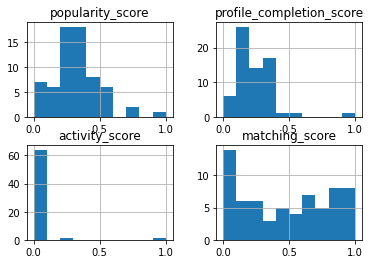

In [61]:
normalized_all_profile_scores_df.hist()

In [62]:
weights = {"popularity_score_weight":0.35,
           "profile_completion_score_weight":0.20,
           "activity_score_weight":0.20,
           "matching_score_weight":0.30}

In [63]:
for columnName in list(normalized_all_profile_scores_df.columns):
    normalized_all_profile_scores_df[columnName + "_weighted"]= normalized_all_profile_scores_df[columnName] * weights[columnName+"_weight"]
normalized_all_profile_scores_df["total_score"] = normalized_all_profile_scores_df[[name for name in normalized_all_profile_scores_df.columns if "weighted" in name]].sum(axis=1)
normalized_all_profile_scores_df["user_rank"] = normalized_all_profile_scores_df["total_score"].rank()

In [65]:
normalized_all_profile_scores_df

,popularity_score,profile_completion_score,activity_score,matching_score,popularity_score_weighted,profile_completion_score_weighted,activity_score_weighted,matching_score_weighted,total_score,user_rank
userId,,,,,,,,,,
06TgfRGj5ssVFQBR,0.333333,0.154535,0.0,0.897636,0.116667,0.030907,0.0,0.269291,0.416865,54.0
0RNSh7XU6uxKkX95,0.266667,0.360518,0.0,0.440860,0.093333,0.072104,0.0,0.132258,0.297695,32.0
1KNmLbYCKBtGGeRb,0.000000,0.309070,0.0,0.342071,0.000000,0.061814,0.0,0.102621,0.164435,12.0
2O7Sxjk2K8Z9Zbir,0.000000,0.360518,0.0,0.043017,0.000000,0.072104,0.0,0.012905,0.085009,2.0
2Pnzu3gOeCMm4XqG,0.266667,0.154535,0.0,0.789661,0.093333,0.030907,0.0,0.236898,0.361139,43.0
...,...,...,...,...,...,...,...,...,...,...
xUNQA8a6ShBk8vg7,0.733333,0.205983,0.0,0.041708,0.256667,0.041197,0.0,0.012512,0.310376,36.0
y39LCk1SCOw2gBiG,0.733333,0.309070,0.0,0.219662,0.256667,0.061814,0.0,0.065899,0.384379,49.0
yCvln20Ent2yvYf5,0.600000,0.360518,0.0,0.676019,0.210000,0.072104,0.0,0.202806,0.484909,63.0


array([[<AxesSubplot:title={'center':'popularity_score'}>,
        <AxesSubplot:title={'center':'profile_completion_score'}>,
        <AxesSubplot:title={'center':'activity_score'}>],
       [<AxesSubplot:title={'center':'matching_score'}>,
        <AxesSubplot:title={'center':'popularity_score_weighted'}>,
        <AxesSubplot:title={'center':'profile_completion_score_weighted'}>],
       [<AxesSubplot:title={'center':'activity_score_weighted'}>,
        <AxesSubplot:title={'center':'matching_score_weighted'}>,
        <AxesSubplot:title={'center':'total_score'}>],
       [<AxesSubplot:title={'center':'user_rank'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

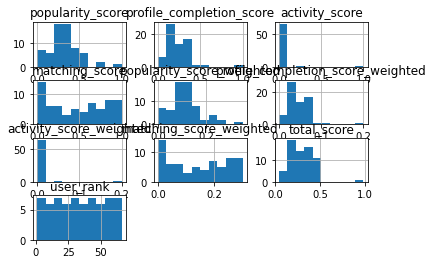

In [66]:
normalized_all_profile_scores_df.hist()

In [69]:
normalized_all_profile_scores_df["user_rank"].min()

1.0

In [18]:
for row in normalized_all_profile_scores_df.iterrows():
    print(row)
    break

NameError: name 'normalized_all_profile_scores_df' is not defined

In [17]:
docs = db.collection('LikesDislikes').document("QvV4OoZmZ3QWHhMNaZrr7lkqmLF3").collection("Given").stream()
for doc in docs:
    print(doc.id)

p7Gws6QkWxz0v4lm
penesHeuqWtQu5ZA
xUNQA8a6ShBk8vg7
y39LCk1SCOw2gBiG
yCvln20Ent2yvYf5
zI9DqdXcrEenpKk8QjccnNVY4KA3
zopU4FMeBKzzQx7z


# Listening to evets and updates on firebase

### Impt links to understand listners
#### 1. Firebase documentation: https://firebase.google.com/docs/firestore/query-data/listen
#### 2. Is there a limit on number of listners: https://stackoverflow.com/questions/27583746/firebase-limit-on-the-number-of-observers-listeners
#### 3. Best practises for real time update: https://cloud.google.com/firestore/docs/best-practices#realtime_updates

In [3]:
# Common attributes 
# Create an Event for notifying main thread.
callback_done = threading.Event()

### How to subscribe to collections or on query data

In [12]:
# Create a callback on_snapshot function to capture changes
def on_snapshot(col_snapshot, changes, read_time):
    print("Again Snapshot called")
    for doc in col_snapshot:
        print(f'{doc.id}')
    callback_done.set()

# You can listen on documents with a where columnd. Here the data will only listen to data where age == 27
# col_query = db.collection(u'Profiles').where('age', '==', 27)
# you can also listen on all documents of a collection
col_query = db.collection(u'Profiles')

# Watch the collection query
query_watch = col_query.on_snapshot(on_snapshot)

Again Snapshot called


In [3]:
# Unsuscribe from all the listeners
query_watch.unsubscribe()

NameError: name 'query_watch' is not defined

$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
REMOVED
{'wasUpdated': True}
$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
ADDED
{'wasUpdated': True}


### Matching Algorithms

In [ ]:
# analyzing the change respnse
# print(dir(change)) # Show the parameters of the change 
# print(vars(change)) # Show the values inside the change object
# print(vars(change.document)) # Show the values inside the change object document
# print(change.type.name)    
# print(change.document._data)

In [44]:
import asyncio
import threading
import traceback
import time

from ProjectConf.FirestoreConf import async_db, db

# Trigger this file to run Matching engine
# Matching Engine starts from here

callback_done = threading.Event()

# logic to check the match between the 2 users
async def calculate_the_match(firstUserSwipe=None,secondUserSwipe=None):
    try:
        if firstUserSwipe == "Likes":
            if secondUserSwipe == "Likes": return "Match"
            if secondUserSwipe == "Superlikes": return "Match"
            if secondUserSwipe == "Dislikes": return "NoMatch"
        elif firstUserSwipe == "Superlikes":
            if secondUserSwipe == "Like": return "Match"
            if secondUserSwipe == "Dislikes": return "NoMatch"
            if secondUserSwipe == "Superlikes": return "Match"
        elif firstUserSwipe == "Dislikes":
            if secondUserSwipe == "Superlikes": return "NoMatch"
            if secondUserSwipe == "Likes": return "NoMatch"
            if secondUserSwipe == "Dislikes": return "NoMatch"
    except Exception as e:
        print(traceback.format_exc())        
        return False               


# When a user swipes the LikesDislikes collection is updated, the listener listens to update and calls this function
# for the user who just swiped, send the id of user who just swiped to function check_the_match
async def check_the_subcollection_for_matches(giverId=None):
    # we fetch only the newSwipes by Checking if matchVerified is not True
    newSwipes = await async_db.collection("LikesDislikes").document(giverId).collection("Given").where(u'matchVerified', u'==', False).stream()
    for swipe in newSwipes:
        # Get the id of user who received the swipe
        receiverId = swipe.id
        # Data of user who gave the swipe
        giverSwipeData = swipe.to_dict()
        # Get the doc for user who received the swipe
        receiverSwipeDataDoc =  await async_db.collection("LikesDislikes").document(receiverId).collection("Given").document(receiverId).get()
        receiverSwipeData = receiverSwipeDataDoc.to_dict()
        print(giverSwipeData)
        # check if receiverSwipeData is None
        # if below condition is true that means this is second swipe. that means both users have swiped on each other
        # else this was the first swipe
        if receiverSwipeData:
            # both users swiped on each other
            print(receiverSwipeData)
            # find the match between two users
            match = await calculate_the_match(firstUserSwipe=receiverSwipeData["swipe"],
                                        secondUserSwipe=giverSwipeData["swipe"])
            # write the match to firebase
            await async_db.collection(u'MatchingEngine').add({"firstUserId":receiverId,
                "secondUserId":giverId,
                "firstUserSwipe":receiverSwipeData["swipe"],
                "secondUserSwipe":giverSwipeData["swipe"],
                "firstUserNotified":False,
                "secondUserNotified":False,
                "timestsamp":time.time(),
                "matchingInfo":match
            })
        else:
            # first swipe, wait for the second user to swipe too
            print("Waiting on second user to swipe")
        # set the matchVerified = True, because we have processed this new swipe
        await async_db.collection("LikesDislikes").document(giverId).collection("Given").document(receiverId).update({'matchVerified':True})
    
# here each change that is listened to is processed
async def match_the_swipe(change=None):
    print("##############")
    if change.type.name == 'ADDED':
        print(f'{change.document.id} added ')
        _ = await check_the_subcollection_for_matches(giverId=change.document.id)
    elif change.type.name == 'MODIFIED':
        print(f'{change.document.id} modified')
    elif change.type.name == 'REMOVED':
        print(f'{change.document.id} removed')
        callback_done.set()

# this function will be called every time firebase hears a change on a document in LikesDislikes
async def matching_engine_listener(col_snapshot, changes, read_time):
    _ = await asyncio.gather(*[match_the_swipe(change=change) for change in changes])

async def matching_engine_trigger():
    # Query the documents inside LikesDislikes collection where wasUpdated == true
    # if wasUpdated == true that means the user gave a new like/dislike/superlike
    col_query = db.collection(u'LikesDislikes').where(u'wasUpdated', '==', True)
    # Watch the collection query
    query_watch = col_query.on_snapshot(matching_engine_listener)
    
    # Unsuscribe from all the listeners
    # query_watch.unsubscribe()


In [ ]:
asyncio.run(matching_engine_trigger())

/Users/kshitizsharma/Desktop/AmoreFlask/env/lib/python3.8/site-packages/google/cloud/firestore_v1/watch.py:568: RuntimeWarning: coroutine 'matching_engine_listener' was never awaited
  self._snapshot_callback(keys, appliedChanges, read_time)
